In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
# from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

### Задание 1.

Решите задачу распознавания лиц с помощью SVM с ядром. Попробуйте различные ядра: 'poly', 'rbf', 'sigmoid'.

Подберите гиперпараметры по кросс-валидации.

SVM с каким ядром дал лучший результат?

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)
print(faces.DESCR)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)
.. _labeled_faces_in_the_wild_dataset:

The Labeled Faces in the Wild face recognition dataset
------------------------------------------------------

This dataset is a collection of JPEG pictures of famous people collected
over the internet, all details are available on the official website:

http://vis-www.cs.umass.edu/lfw/

Each picture is centered on a single face. The typical task is called
Face Verification: given a pair of two pictures, a binary classifier
must predict whether the two images are from the same person.

An alternative task, Face Recognition or Face Identification is:
given the picture of the face of an unknown person, identify the name
of the person by referring to a gallery of previously seen pictures of
identified persons.

Both Face Verification and Face Recognition are tasks that are typically
performed on the out

In [ ]:
# Подготовка данных
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, test_size=0.2, random_state=42)
pca = PCA(n_components=150, whiten=True, random_state=42)
Xtrain = pca.fit_transform(Xtrain)
Xtest = pca.transform(Xtest)

In [ ]:
# SVM с полиномиальным ядром
param_grid_poly = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01],
    'degree': [2, 3],
}

grid_poly = GridSearchCV(SVC(kernel='poly', class_weight='balanced'), param_grid_poly, cv=5)
grid_poly.fit(Xtrain, ytrain)

print('Лучшие параметры для SVM с полиномиальным ядром:', grid_poly.best_params_)
print('Точность:', grid_poly.best_score_)

Лучшие параметры для Poly: {'C': 10, 'degree': 2, 'gamma': 0.01}
Точность Poly: 0.6057235142118863


In [ ]:
# SVM с RBF-ядром (Radial Basis Function)
param_grid_rbf = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.0001, 0.001, 0.01, 0.1],
}

grid_rbf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid_rbf, cv=5)
grid_rbf.fit(Xtrain, ytrain)

print('Лучшие параметры для SVM с RBF:', grid_rbf.best_params_)
print('Точность:', grid_rbf.best_score_)

Лучшие параметры для RBF: {'C': 10, 'gamma': 0.0001}
Точность RBF: 0.8200215331610681


In [ ]:
# SVM с сигмоидным ядром
param_grid_sigmoid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01],
}

grid_sigmoid = GridSearchCV(SVC(kernel='sigmoid', class_weight='balanced'), param_grid_sigmoid, cv=5)
grid_sigmoid.fit(Xtrain, ytrain)

print('Лучшие параметры для SVM с сигмоидным ядром:', grid_sigmoid.best_params_)
print('Точность:', grid_sigmoid.best_score_)

Лучшие параметры для Sigmoid: {'C': 10, 'gamma': 0.001}
Точность Sigmoid: 0.7977476313522824


In [ ]:
# SVM с линейным ядром
param_grid_linear = {'C': [0.1, 1, 10]}

grid_linear = GridSearchCV(SVC(kernel='linear', class_weight='balanced'), param_grid_linear, cv=5)
grid_linear.fit(Xtrain, ytrain)

print('Лучшие параметры для SVM с линейным ядром:', grid_linear.best_params_)
print('Точность:', grid_linear.best_score_)

Лучшие параметры для Linear: {'C': 1}
Точность Linear: 0.7754866494401378


In [ ]:
# Наибольшая точность у модели с RBF-ядром, предсказание для данной модели
best_model = grid_rbf.best_estimator_
ypred = best_model.predict(Xtest)

print(classification_report(ytest, ypred, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.83      0.74        12
     Colin Powell       0.86      0.86      0.86        51
  Donald Rumsfeld       0.79      0.88      0.83        25
    George W Bush       0.95      0.83      0.89        98
Gerhard Schroeder       0.79      0.71      0.75        21
      Hugo Chavez       0.73      0.73      0.73        15
Junichiro Koizumi       0.91      1.00      0.95        10
       Tony Blair       0.78      0.95      0.86        38

         accuracy                           0.85       270
        macro avg       0.81      0.85      0.83       270
     weighted avg       0.86      0.85      0.85       270



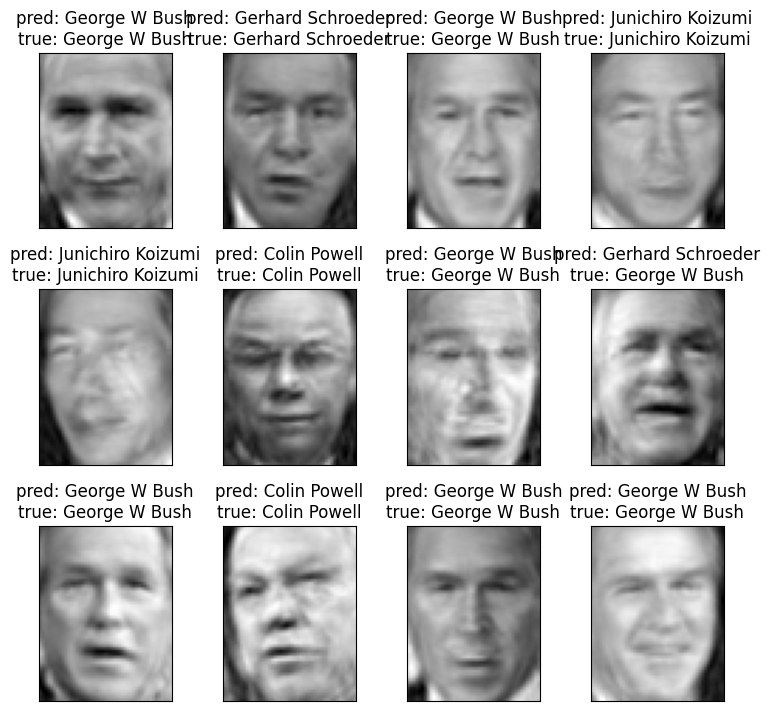

In [ ]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4): # «слизанная» визуализация
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

h, w = faces.images.shape[1], faces.images.shape[2]
# Предсказания для части тестовых данных
prediction_titles = [f"pred: {faces.target_names[ypred[i]]}\ntrue: {faces.target_names[ytest[i]]}"
                     for i in range(12)]

plot_gallery(pca.inverse_transform(Xtest), prediction_titles, h, w)
plt.show()

### Задание 2.

Решите задачу распознавания лиц с помощью логистической регрессии (она также поддерживает опцию class_weight='balanced'):

1) Объявите модель, состоящую из pipeline(pca,logistic regression)

2) Подберите по сетке параметр C логистической регрессии (с помощью GridSearch)

3) Обучите модель на тренировочных данных и выведите наилучшие параметры модели

Какое качество показала эта модель?

In [ ]:
Xtrain_lr, Xtest_lr, ytrain_lr, ytest_lr = train_test_split(faces.data, faces.target, test_size=0.2, random_state=42)

lr = LogisticRegression(penalty='l2', class_weight='balanced', random_state=42)
pca_lr = PCA(n_components=150, svd_solver='randomized', whiten=True, random_state=42)
model = make_pipeline(pca_lr, lr)

param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

grid.fit(Xtrain_lr, ytrain_lr)
print('Лучшие параметры:', grid.best_params_)
print('Лучшая точность (CV): {:.2f}'.format(grid.best_score_))

Лучшие параметры: {'logisticregression__C': 0.1}
Лучшая точность (CV): 0.82


In [ ]:
best_model = grid.best_estimator_
ypred_lr = best_model.predict(Xtest_lr)
print(classification_report(ytest_lr, ypred_lr, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.67      0.67        12
     Colin Powell       0.86      0.86      0.86        51
  Donald Rumsfeld       0.78      0.84      0.81        25
    George W Bush       0.91      0.79      0.84        98
Gerhard Schroeder       0.71      0.71      0.71        21
      Hugo Chavez       0.77      0.67      0.71        15
Junichiro Koizumi       0.91      1.00      0.95        10
       Tony Blair       0.72      0.95      0.82        38

         accuracy                           0.82       270
        macro avg       0.79      0.81      0.80       270
     weighted avg       0.83      0.82      0.82       270



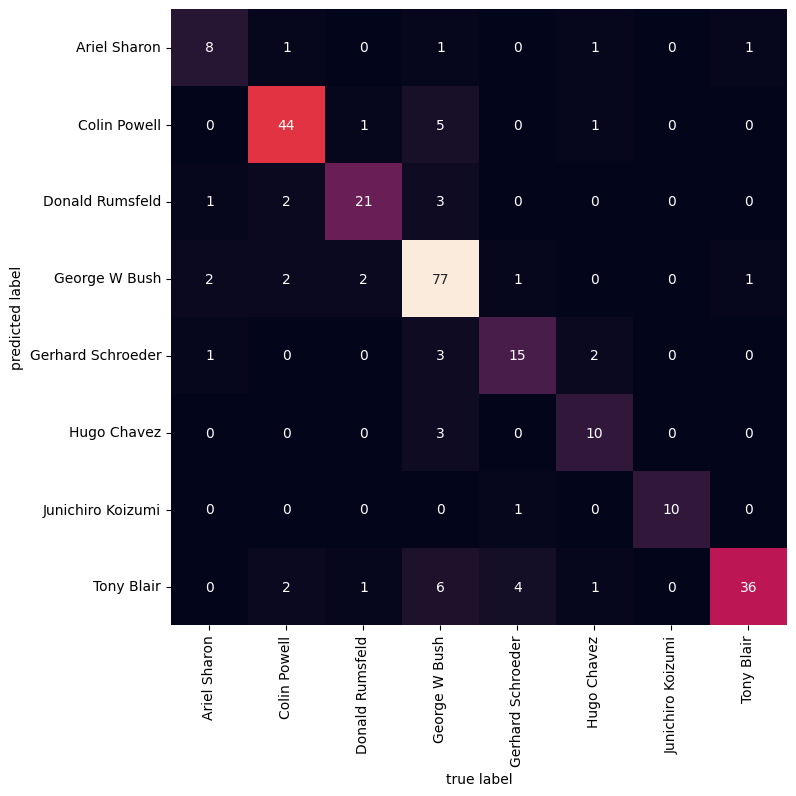

In [ ]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(ytest_lr, ypred_lr)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Задание 3.

Разбалловка:

- 5 баллов: обучили один алгоритм и погридсерчили
- 10 баллов: попробовали обучить два и более алгоритмов, погридсерчили

Поработайте с датасетом winequalityN (целевая переменная - quality). Поэкспериментируйте с алгоритмами классификации, попробуйте подобрать гиперпараметры для них.

In [2]:
!wget https://raw.githubusercontent.com/rsuh-python/mag2024ML/refs/heads/main/04-ClassificationTrees/winequalityN.csv

--2025-04-07 13:57:29--  https://raw.githubusercontent.com/rsuh-python/mag2024ML/refs/heads/main/04-ClassificationTrees/winequalityN.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383878 (375K) [text/plain]
Saving to: ‘winequalityN.csv’

winequalityN.csv    100%[===================>] 374.88K  --.-KB/s    in 0.04s   

2025-04-07 13:57:29 (8.21 MB/s) - ‘winequalityN.csv’ saved [383878/383878]



In [32]:
data = pd.read_csv('winequalityN.csv')
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


#### Подготовка данных

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [34]:
data.type.unique()

array(['white', 'red'], dtype=object)

In [35]:
data.quality.value_counts().sort_index()

,count
quality,
3,30
4,216
5,2138
6,2836
7,1079
8,193
9,5


In [36]:
data['type_wine'] = data['type'].map({'white': 0, 'red': 1})
data.drop('type', axis=1, inplace=True)

<Axes: >

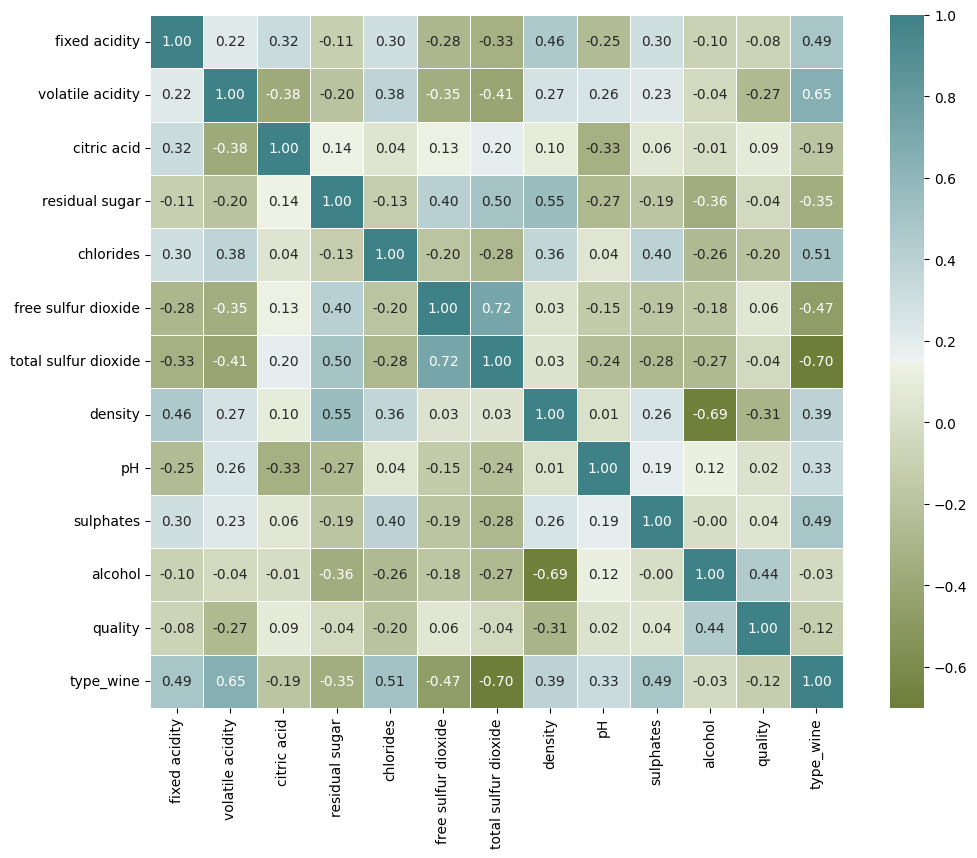

In [37]:
plt.figure(figsize=(12,9))

corr = data.corr()

sns.heatmap(corr,annot=True,linewidths=.5,fmt= '.2f',\
            mask=np.zeros_like(corr, dtype=bool), \
            cmap=sns.diverging_palette(100,200,as_cmap=True), square=True)

In [38]:
data.drop('free sulfur dioxide', axis=1, inplace=True)

In [39]:
columns_to_fill = ['sulphates', 'pH', 'fixed acidity', 'volatile acidity',
                  'citric acid', 'residual sugar', 'chlorides']

for column in columns_to_fill:
    data[column] = data[column].fillna(data[column].median())

#### Обучение моделей и предсказания

**KNN**

In [62]:
X = data.drop('quality', axis=1)
y = data.quality

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

hyperparams = list(range(2, 30))
param_grid = {'knn__n_neighbors': hyperparams}
grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

best_knn = grid.best_estimator_
print('Лучшие параметры:', grid.best_params_)

Лучшие параметры: {'knn__n_neighbors': 27}


In [58]:
y_pred = best_knn.predict(X_test)
print('Test Accuracy:', accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.5515384615384615
[[  0   0   2   0   0   0]
 [  0   0  23  23   0   0]
 [  0   0 266 150   4   0]
 [  0   0 144 379  56   0]
 [  0   0  10 139  72   0]
 [  0   0   0  19  13   0]]


Результат не очень, скорее всего из-за дисбаланса классов в датасете.

In [63]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=0.95)), # +
    ('knn', KNeighborsClassifier(weights='distance')) # из документации:
    # in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away
])

hyperparams = list(range(2, 30))
param_grid = {
    'knn__n_neighbors': hyperparams,
    'knn__metric': ['euclidean', 'manhattan']} # добавлены метрики
grid = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro') # замена скора
grid.fit(X_train, y_train)

best_knn = grid.best_estimator_
print('Лучшие параметры:', grid.best_params_)

Лучшие параметры: {'knn__metric': 'euclidean', 'knn__n_neighbors': 7}


Уже сильно изменился параметр и точность в итоге.

In [64]:
y_pred = best_knn.predict(X_test)
print('Test Accuracy:', accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.6576923076923077
[[  0   0   2   0   0   0]
 [  0   7  23  13   3   0]
 [  0   5 301 108   6   0]
 [  0   1  92 417  64   5]
 [  0   1  11  79 124   6]
 [  0   0   0  16  10   6]]
